In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import coo_array

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# Build the mesh and weighted adjacency matrix

In [2]:
# Semicircular track parameters
INNER_RADIUS = 7
OUTER_RADIUS = 10

# Mesh parameters, H ~ radial, K ~ arc
H = 5
K = 14

## Old approach

In [3]:
track_iter = np.zeros((2,H))
track_iter[0,:] = np.linspace(INNER_RADIUS, OUTER_RADIUS, H)
pd.DataFrame(track_iter)

,0,1,2,3,4
0,7.0,7.75,8.5,9.25,10.0
1,0.0,0.00,0.0,0.00,0.0


In [4]:
def iterate_track_arc(theta, track_iter):
    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta),  np.cos(theta)]])
    
    next_track_iter = R@track_iter
    nondiag_distances = np.linalg.norm(next_track_iter - track_iter, axis=0)

    return next_track_iter, nondiag_distances

In [5]:
track_iter, nondiag_distances = iterate_track_arc(np.pi/K, track_iter)
diag_distances = None
pd.DataFrame(nondiag_distances)

,0
0,1.567503
1,1.735449
2,1.903396
3,2.071343
4,2.239290


## New approach

The previous approach was based on the idea of computing entries in the weighted adjacency matrix during each iteration, possibly reusing the cos/sin calculations while computing the norm.
I determined that this would probably have negligible gains, if any at all, over the more modular/readable style of computing the mesh first, then the weighted adjacency matrix after.

The following is a simple, partially vectorized method to compute the mesh. Not much to say about it, I chose to vectorize along the larger dimension K to reduce iteration.

In [6]:
def arc(thetas, radius):
    return radius * np.array([np.cos(thetas),np.sin(thetas)])

In [7]:
thetas = np.linspace(0, np.pi, K)
radii = np.linspace(INNER_RADIUS, OUTER_RADIUS, H)
# print(arc(thetas[:-1], radii[H-1]))

mesh = np.zeros((2,K,H))
for i, radius in enumerate(radii):
    mesh[:,:,i] = arc(thetas, radius)

#mesh[:,20,40]

## Adjacency matrix

When theta is invariant, the distance between adjacent points on the radial axis is constant. ||*|| is nondiag distance as seen in older method above, ||**|| is diag distance

|          | (th0,r0) | (th0,r1) | ... | (th0,rH) | (th1,r0)   | ... | ... | (thK,rH) |
|----------|----------|----------|-----|----------|------------|-----|-----|----------|
| (th0,r0) | 0        | (OUTER-INNER)/H     | ... | 0        | \|\|*\|\|  |     |     |          |
| (th0,r1) |          | 0        | ... |          | \|\|**\|\| |     |     |          |
| ...      |          |          |     |          |            |     |     |          |

In [16]:
weighted_adj = np.zeros((H*K,H*K))

for theta_i, radius_i, in np.ndindex(mesh.shape[1:]):
    # Collect the indices for distance calculation #
    adj_i = H*theta_i + radius_i
    adj_j = []

    if radius_i != H-1:  # Not on outer edge (covers all radial)
        adj_j.append(adj_i + 1)
        
    if theta_i != K-1:  # Not at end of track segment (prereq for forward/diagonal)
        
        if radius_i != 0:  # Permits inner diag
            adj_j.append(adj_i + H-1)
            
        adj_j.append(adj_i + H)  # Directly forward

        if radius_i != H-1:  # Permits outer diag
            adj_j.append(adj_i + H+1)

    print(list(zip([adj_i for _ in adj_j], adj_j)))
        
    #print(f"T:{theta_i}, R:{radius_i} : {mesh[:,theta_i,radius_i]}")

[(0, 1), (0, 5), (0, 6)]
[(1, 2), (1, 5), (1, 6), (1, 7)]
[(2, 3), (2, 6), (2, 7), (2, 8)]
[(3, 4), (3, 7), (3, 8), (3, 9)]
[(4, 8), (4, 9)]
[(5, 6), (5, 10), (5, 11)]
[(6, 7), (6, 10), (6, 11), (6, 12)]
[(7, 8), (7, 11), (7, 12), (7, 13)]
[(8, 9), (8, 12), (8, 13), (8, 14)]
[(9, 13), (9, 14)]
[(10, 11), (10, 15), (10, 16)]
[(11, 12), (11, 15), (11, 16), (11, 17)]
[(12, 13), (12, 16), (12, 17), (12, 18)]
[(13, 14), (13, 17), (13, 18), (13, 19)]
[(14, 18), (14, 19)]
[(15, 16), (15, 20), (15, 21)]
[(16, 17), (16, 20), (16, 21), (16, 22)]
[(17, 18), (17, 21), (17, 22), (17, 23)]
[(18, 19), (18, 22), (18, 23), (18, 24)]
[(19, 23), (19, 24)]
[(20, 21), (20, 25), (20, 26)]
[(21, 22), (21, 25), (21, 26), (21, 27)]
[(22, 23), (22, 26), (22, 27), (22, 28)]
[(23, 24), (23, 27), (23, 28), (23, 29)]
[(24, 28), (24, 29)]
[(25, 26), (25, 30), (25, 31)]
[(26, 27), (26, 30), (26, 31), (26, 32)]
[(27, 28), (27, 31), (27, 32), (27, 33)]
[(28, 29), (28, 32), (28, 33), (28, 34)]
[(29, 33), (29, 34)]
[(30,

In [10]:
pd.DataFrame(mesh[0,:,:])

,0,1,2,3,4
0,7.000000,7.750000,8.500000,9.250000,10.000000
1,6.796593,7.524799,8.253005,8.981212,9.709418
2,6.198192,6.862284,7.526376,8.190468,8.854560
3,5.239575,5.800958,6.362341,6.923724,7.485107
4,3.976453,4.402502,4.828550,5.254599,5.680647
5,2.482234,2.748188,3.014142,3.280095,3.546049
6,0.843757,0.934159,1.024562,1.114964,1.205367
7,-0.843757,-0.934159,-1.024562,-1.114964,-1.205367
8,-2.482234,-2.748188,-3.014142,-3.280095,-3.546049
9,-3.976453,-4.402502,-4.828550,-5.254599,-5.680647


In [11]:
np.ravel(mesh[0,:,:])

array([  7.        ,   7.75      ,   8.5       ,   9.25      ,
        10.        ,   6.79659272,   7.52479909,   8.25300545,
         8.98121181,   9.70941817,   6.19819218,   6.8622842 ,
         7.52637622,   8.19046824,   8.85456026,   5.23957524,
         5.8009583 ,   6.36234136,   6.92372442,   7.48510748,
         3.97645323,   4.40250179,   4.82855035,   5.25459891,
         5.68064747,   2.48223421,   2.74818787,   3.01414154,
         3.28009521,   3.54604887,   0.84375676,   0.93415927,
         1.02456178,   1.11496429,   1.2053668 ,  -0.84375676,
        -0.93415927,  -1.02456178,  -1.11496429,  -1.2053668 ,
        -2.48223421,  -2.74818787,  -3.01414154,  -3.28009521,
        -3.54604887,  -3.97645323,  -4.40250179,  -4.82855035,
        -5.25459891,  -5.68064747,  -5.23957524,  -5.8009583 ,
        -6.36234136,  -6.92372442,  -7.48510748,  -6.19819218,
        -6.8622842 ,  -7.52637622,  -8.19046824,  -8.85456026,
        -6.79659272,  -7.52479909,  -8.25300545,  -8.98

## Mesh Sanity Check

In [12]:
x = np.ravel(mesh[0,:,:])
y = np.ravel(mesh[1,:,:])

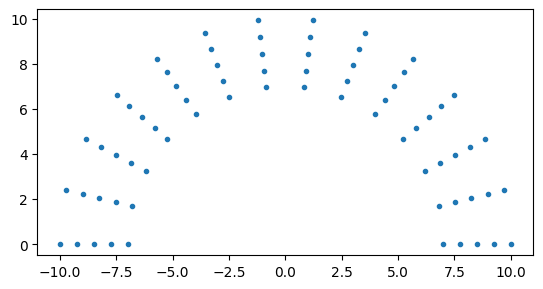

In [13]:
plt.scatter(x, y, marker='.')
plt.gca().set_aspect('equal')
plt.show()